In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import pathlib
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
import itertools

2023-05-05 15:25:48.929646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
for dirpath, dirnames, filenames in os.walk("Dataset"):
    print(f"{len(dirnames)} dirs and {len(filenames)} images in '{dirpath}'")

3 dirs and 0 images in 'Dataset'
0 dirs and 1124 images in 'Dataset/AD'
0 dirs and 1440 images in 'Dataset/CN'
0 dirs and 2590 images in 'Dataset/MCI'


In [6]:
data_dir = "Dataset/"
path_dir = pathlib.Path("Dataset")
class_names = np.array(sorted([item.name for item in path_dir.glob('*')]))
print(class_names)

['AD' 'CN' 'MCI']


In [7]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}")
    return img

Image shape: (256, 160)


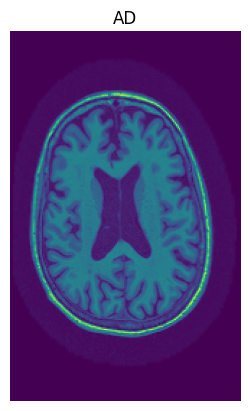

In [8]:
img = view_random_image(data_dir, class_names[0])

Image shape: (256, 166)


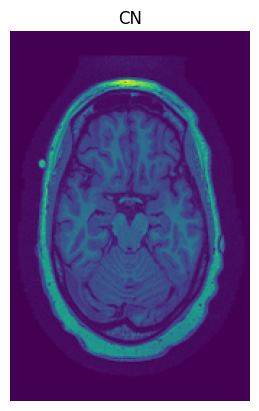

In [9]:
img = view_random_image(data_dir, class_names[1])

Image shape: (256, 160)


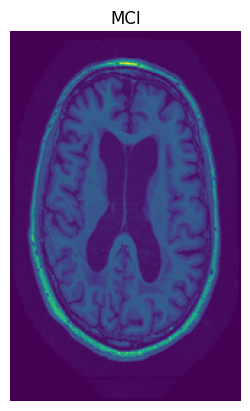

In [10]:
img = view_random_image(data_dir, class_names[2])

In [11]:
# For replicable results
SEED = 0
# Size of the images is (128,128)
IMAGE_SIZE = (256, 180)
# Default batch size
BATCH_SIZE = 32
# Images are grayscale
COLOR_MODE = "grayscale"
# 20% test split
VAL_SPLIT = 0.2

tf.random.set_seed(SEED)
np.random.seed(SEED)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=VAL_SPLIT,
    subset="validation",
    label_mode='categorical',
    seed=SEED,
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5154 files belonging to 3 classes.
Using 4124 files for training.
Found 5154 files belonging to 3 classes.
Using 1030 files for validation.


In [13]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True
inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE+(1,)), name="input_layer")
# Efficient net model has the normalizing layer builtin
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)

16705208/16705208 [==============================] - 1s 0us/step


In [14]:
model = tf.keras.Model(inputs, outputs)

In [16]:
# Default Learning rate
LR = 0.001

model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                metrics=["accuracy"])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 180, 1)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 4,011,391
Non-trainable params: 42,023
_________________________________________________________________


In [18]:
# Epochs
EPOCHS = 20
history = model.fit(train_data,
                      validation_data=valid_data,
                      epochs=EPOCHS,
                      verbose=False
                      )

2023-05-05 15:31:39.576382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4124]
	 [[{{node Placeholder/_4}}]]
2023-05-05 15:31:39.577408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4124]
	 [[{{node Placeholder/_0}}]]


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10, 7));

In [ ]:
model.evaluate(valid_data)